### Import Libraries

In [2]:
from transformers import CLIPSegProcessor, CLIPSegForImageSegmentation
from matplotlib import pyplot as plt
from PIL import Image
from skimage.filters import threshold_otsu

import cv2
import torch
import numpy as np

d:\Development\anaconda\anaconda\envs\ffb\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Load Model

In [3]:
from transformers import CLIPSegProcessor, CLIPSegForImageSegmentation
from matplotlib import pyplot as plt

# Load model and its processor from the hub
processor = CLIPSegProcessor.from_pretrained(r"D:\Development\projects\fusionex\ffb\models\models--CIDAS--clipseg-rd64-refined")
model = CLIPSegForImageSegmentation.from_pretrained(r"D:\Development\projects\fusionex\ffb\models\models--CIDAS--clipseg-rd64-refined")
"CIDAS/clipseg-rd64-refined"


# # Load model and its processor from the locally
# processor = CLIPSegProcessor.from_pretrained(r"models/models_folder_name")
# model = CLIPSegForImageSegmentation.from_pretrained(r"models/model_folder_name")

'CIDAS/clipseg-rd64-refined'

### Forward Pass

In [4]:
# Display result images
def show_image(results,titles):
    _, ax = plt.subplots(2, 2)
    [a.axis('off') for a in ax.flatten()]
    plt.subplots_adjust(wspace=0.01, hspace=0.2)
    for i, (image,title) in enumerate(zip(results,titles)):
        row = i // 2  # Calculate the row index (0 or 1)
        col = i % 2   # Calculate the column index (0 or 1)
        ax[row, col].imshow(image)
        ax[row, col].set_title(title)

#### Text Prompt

In [5]:
def forward_pass_text(image,prompts,model,processor):

    inputs = processor(text=prompts, images=[image] * len(prompts), padding="max_length", return_tensors="pt")
    image_np = np.array(image)

    with torch.no_grad():
        outputs = model(**inputs)
    preds = outputs.logits.unsqueeze(1)
    preds = torch.transpose(preds, 0, 1)

    # stack image for display
    np_uint_img = (torch.sigmoid(preds[0]).numpy()*255).astype(np.uint8)
    np_uint_img_resize = cv2.resize(np_uint_img,(image.size[0],image.size[1]))
    np_stacked_img = np.stack((np_uint_img_resize,)*3,axis=-1)

    # binary thresholding
    thresh = threshold_otsu(np_stacked_img)
    binary = np_stacked_img > thresh
    binary_result = binary.astype(np.uint8)*255

    # compute overlay 
    overlay_result = cv2.bitwise_and(np.array(image),binary_result)
    
    image_list = [Image.fromarray(image) for image in [image_np, np_stacked_img, binary_result, overlay_result]]
    title_list = ["input", "heatmap", "binary_mask", "overlay"]

    show_image(image_list,title_list)

C:\Users\Admin\AppData\Local\Temp\ipykernel_20672\3027557729.py:17: UserWarning: threshold_otsu is expected to work correctly only for grayscale images; image shape (1280, 960, 3) looks like that of an RGB image.
  thresh = threshold_otsu(np_stacked_img)


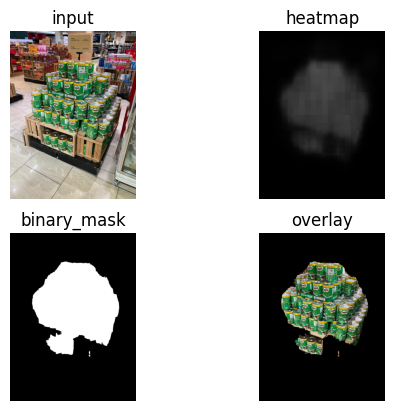

In [7]:
image = Image.open(r"sample_images/target.jpg")
text_prompts = ["milo green packet"]
result = forward_pass_text(image,text_prompts,model,processor)

#### Image Prompt

In [8]:
def forward_pass_image(image,image_prompt,model,processor):

    encoded_image = processor(images=[image], return_tensors="pt")
    encoded_prompt = processor(images=[image_prompt], return_tensors="pt")

    image_np = np.array(image)

    with torch.no_grad():
        outputs = model(**encoded_image, conditional_pixel_values=encoded_prompt.pixel_values)
    preds = outputs.logits.unsqueeze(1)
    preds = torch.transpose(preds, 0, 1)

    # stack image for display
    np_uint_img = (torch.sigmoid(preds[0]).numpy()*255).astype(np.uint8)
    np_uint_img_resize = cv2.resize(np_uint_img,(image.size[0],image.size[1]))
    np_stacked_img = np.stack((np_uint_img_resize,)*3,axis=-1)

    # binary thresholding
    thresh = threshold_otsu(np_stacked_img)
    binary = np_stacked_img > thresh
    binary_result = binary.astype(np.uint8)*255

    # compute overlay 
    overlay_result = cv2.bitwise_and(np.array(image),binary_result)
    
    image_list = [Image.fromarray(image) for image in [image_np, np_stacked_img, binary_result, overlay_result]]
    title_list = ["input", "heatmap", "binary_mask", "overlay"]

    show_image(image_list,title_list)

C:\Users\Admin\AppData\Local\Temp\ipykernel_20672\2580612344.py:19: UserWarning: threshold_otsu is expected to work correctly only for grayscale images; image shape (1280, 960, 3) looks like that of an RGB image.
  thresh = threshold_otsu(np_stacked_img)


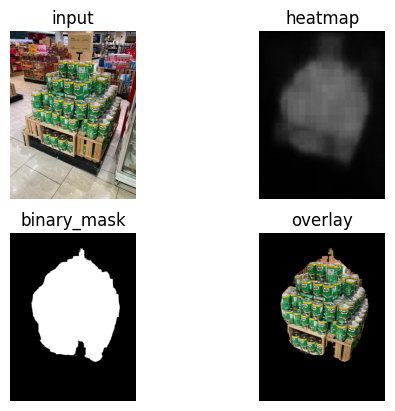

In [9]:
image = Image.open(r"sample_images/target.jpg")
image_prompt = Image.open(r"sample_images/prompt.jpg")
result = forward_pass_image(image,image_prompt,model,processor)